## Шаг 1. Предобработка данных

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np
import math as mth

import warnings

warnings.filterwarnings("ignore")

In [2]:
data_users = pd.read_csv('/datasets/user_source.csv')
display(data_users.head(5), data_users.info(), data_users.isnull().sum(), data_users.duplicated().sum())

print(data_users['source'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


None

user_id    0
source     0
dtype: int64

0

['facebook_ads' 'yandex_direct' 'youtube_channel_reklama'
 'instagram_new_adverts']


In [3]:
data_game_act = pd.read_csv('/datasets/game_actions.csv')
display(data_game_act.head(5), data_game_act.info(), data_game_act.isnull().sum(), data_game_act.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


None

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

1

In [4]:
print(data_game_act['event'].unique())
print() 
print(data_game_act['building_type'].unique())
print()
print(data_game_act['project_type'].unique())
print()
print(data_game_act['event_datetime'].min())
print()
print(data_game_act['event_datetime'].max())

['building' 'finished_stage_1' 'project']

['assembly_shop' 'spaceport' nan 'research_center']

[nan 'satellite_orbital_assembly']

2020-05-04 00:00:01

2020-06-05 12:32:49


Пропуски в building_type и project_type оставляем

In [5]:
#Переводим в формат даты колонку event_datetime
data_game_act['event_datetime'] = pd.to_datetime(data_game_act['event_datetime'])
#Удаляем 1 дубль
data_game_act = data_game_act.drop_duplicates().reset_index(drop=True)

In [6]:
data_ad_сost = pd.read_csv('/datasets/ad_costs.csv')
display(data_ad_сost.head(5), data_ad_сost.info(), data_ad_сost.isnull().sum(), data_ad_сost.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


None

source    0
day       0
cost      0
dtype: int64

0

Пропуски в building_type и project_type оставляем, также был удален дубликат из data_game_act

______

## Шаг 2. Exploratory data analysis

### Сравним количество пользователей, завершивших 1 уровень, PvP и PvE

In [7]:
print('Всего в когорте', data_game_act['user_id'].nunique(), 'уникальных пользователей')

Всего в когорте 13576 уникальных пользователей


____

#### Группа PVE

Посчитаем сколько зданий строят игроки PVE

In [8]:
data_pve_id = data_game_act[(data_game_act['event'] == 'project')]

data_finish = data_game_act[(data_game_act['event'] == 'finished_stage_1')]

data_pve =  data_finish.merge(data_pve_id['user_id'], on='user_id', how='inner')

print(data_pve['user_id'].nunique(), 'пользователей завершили 1 уровень, завершив проект')

1866 пользователей завершили 1 уровень, завершив проект


In [9]:
data_pve = data_game_act.merge(data_pve['user_id'], on = 'user_id', how='right')

In [10]:
data_pve_agg = data_pve.query('event == "building"').groupby('user_id').agg({'event': 'count'}).reset_index()
data_pve_agg.columns = ['user_id', 'count_build']
data_pve_agg['strategy'] = 'PVE'
print(round(data_pve_agg['count_build'].mean(), 2), 'среднее количество зданий на пользователя PVE')
print(data_pve_agg['count_build'].min(), 'минимальное количество зданий на пользователя PVE')
print(data_pve_agg['count_build'].max(), 'максимальное количество зданий на пользователя PVE')
display(data_pve_agg)

12.65 среднее количество зданий на пользователя PVE
10 минимальное количество зданий на пользователя PVE
20 максимальное количество зданий на пользователя PVE


,user_id,count_build,strategy
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,11,PVE
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,12,PVE
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,11,PVE
3,00de2809-403e-4476-a2f7-ca1b11700190,13,PVE
4,00e83261-5fd4-4939-9616-802b5a0202c6,13,PVE
...,...,...,...
1861,ff50f63a-c4b3-494e-8bf9-3f19dbfc513e,18,PVE
1862,ff60fcd1-4329-494e-b82d-461fbdf5b5eb,11,PVE
1863,ff83bdd8-f49a-49fd-8aad-9fa1fb30d516,13,PVE
1864,ff841992-d93b-462e-bc6e-18c24a514f36,20,PVE


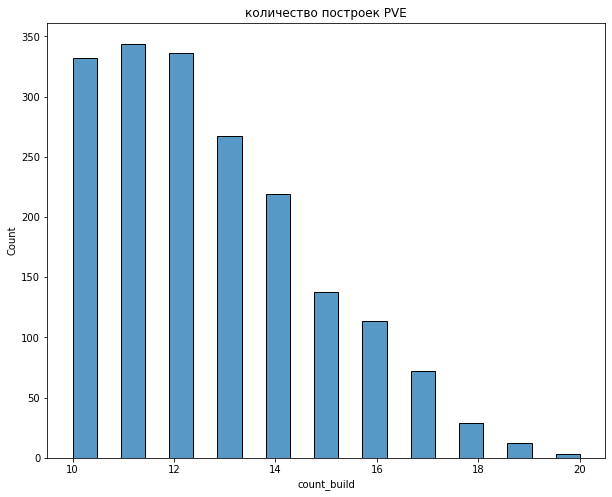

In [11]:
fig, hist = plt.subplots()
hist = sns.histplot(data=data_pve_agg, x="count_build")
hist.set_title('количество построек PVE') 
fig.set_figwidth(10)
fig.set_figheight(8);

____

#### Группа PVP

Посчитаем сколько зданий строяк игроки PVP

In [12]:
# выбираем пользователей, которые завершили уровень без проекта
data_pvp = pd.concat([data_game_act, data_pve]).drop_duplicates(keep=False) #объединяем таблицы и удаляем дубли, чтобы найти пользователей не их группы pve
data_pvp = data_pvp.loc[(data_game_act['event'] == 'finished_stage_1')] #берем тех, кто закончил

display(data_pvp['user_id'].nunique())

3951

In [13]:
data_pvp = data_game_act.merge(data_pvp['user_id'], on='user_id', how='inner')

In [14]:
data_pvp = data_pvp.query('event == "building"').groupby('user_id').agg({'event': 'count'}).reset_index()
data_pvp.columns = ['user_id', 'count_build']
data_pvp['strategy'] = 'PVP'
print(round(data_pvp['count_build'].mean(), 2), 'среднее количество зданий на пользователя PVP')
print(data_pvp['count_build'].min(), 'минимальное количество зданий на пользователя PVP')
print(data_pvp['count_build'].max(), 'максимальное количество зданий на пользователя PVP')

9.41 среднее количество зданий на пользователя PVP
2 минимальное количество зданий на пользователя PVP
19 максимальное количество зданий на пользователя PVP


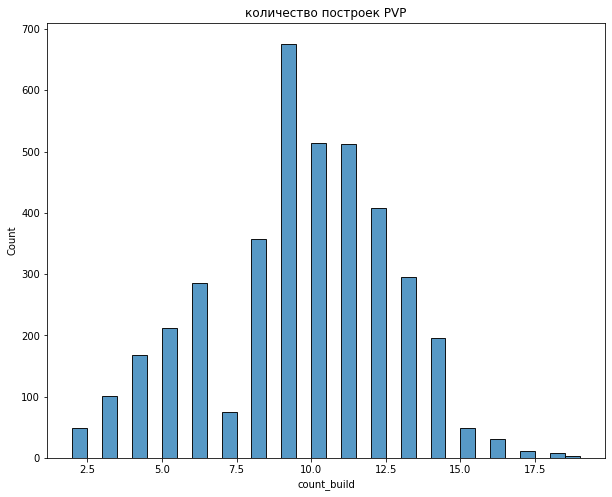

In [15]:
fig, hist = plt.subplots()
hist = sns.histplot(data=data_pvp, x="count_build")
hist.set_title('количество построек PVP') 
fig.set_figwidth(10)
fig.set_figheight(8);

Пользователи PVP в среднем строят на 3 здания меньше, но надо учесть, что их почти в 2 раза больше, чем пользователей PVE

### Общее количество зданий

In [16]:
print(data_game_act[data_game_act['event'] == 'building']['event'].count(), 'всего было построено зданий')

127956 всего было построено зданий


### Среднее количество построек на пользователя 

In [17]:
print(round(data_game_act.query('event == "building"').groupby('user_id').agg({'event': 'count'}).median(), 2), 'среднее количество зданий на пользователя')

event    10.0
dtype: float64 среднее количество зданий на пользователя


### Периодичность построек

In [18]:
data_act_buil = data_game_act.query('event == "building"')

data_act_buil['prev'] = (data_act_buil.query('event == "building"').sort_values(by=['event_datetime'], ascending=True)
                       .groupby(['user_id'])['event_datetime'].shift(1))

data_act_buil['diff'] = data_act_buil['event_datetime'] - data_act_buil['prev']

print('в среднем времени между каждой постройков проходит', data_act_buil['diff'].median()) #используем медиану, чтобы избежать выбросов

в среднем времени между каждой постройков проходит 0 days 20:17:22.500000


In [19]:
day_f = data_game_act.query('event == "building"').groupby('user_id').apply(lambda x: x['event_datetime'].max() - x['event_datetime'].min()).dt.round('D').reset_index()
day_f.columns = ['user_id', 'time']
day_f['time'] = (day_f['time']/ np.timedelta64(1, 'D')).astype(int) #переводим в формат int
print('от первой постройки до последней в среднем проходит', day_f['time'].median(), 'дней')

от первой постройки до последней в среднем проходит 10.0 дней


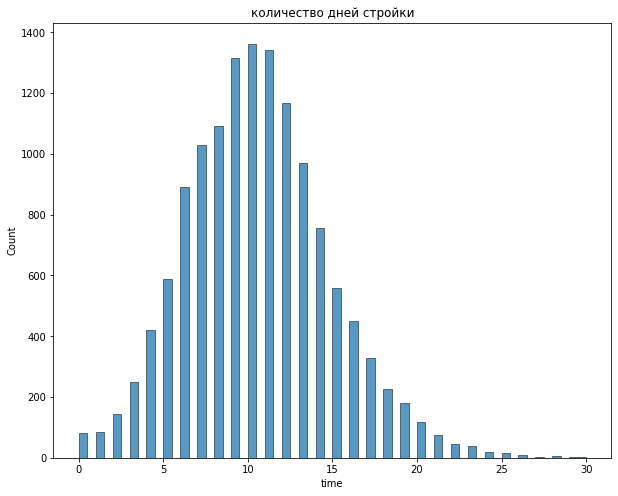

In [20]:
fig, hist = plt.subplots()
hist = sns.histplot(data=day_f, x="time")
hist.set_title('количество дней стройки') 
fig.set_figwidth(10)
fig.set_figheight(8);

###  Проанализировать влияние событий на совершение целевого события (переход на 2 уровень)

Разделим пользователей на, завершивших уровень (1) и не завершивших (0), и сверим их показатели

In [21]:
#создаем df с пользователями, которые завершили уровень
data_finished = data_game_act.merge(data_finish['user_id'], on = 'user_id', how='right')
display(data_finished['user_id'].nunique())

#создаем df с пользователями, которые не завершили уровень
data_not_finished = pd.concat([data_game_act, data_finished]).drop_duplicates(keep=False)
display(data_not_finished['user_id'].nunique())

5817

7759

#### среднее количество времени, проведенное пользователем на 1 уровне

от первой постройки до последней в среднем проходит 10.772035398230088 дней


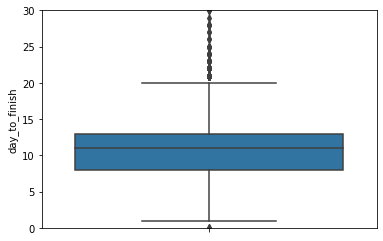

In [22]:
day_to_f = data_finished.query('event == "building"').groupby('user_id').apply(lambda x: x['event_datetime'].max() - x['event_datetime'].min()).dt.round('D').reset_index()
day_to_f.columns = ['user_id', 'day_to_finish']
day_to_f['day_to_finish'] = (day_to_f['day_to_finish']/ np.timedelta64(1, 'D')).astype(int) #переводим в формат int

sns.boxplot(y='day_to_finish', data=day_to_f)
plt.ylim(0, 30);

day_to_f = day_to_f[day_to_f['day_to_finish'] < 20]
print('от первой постройки до последней в среднем проходит', day_to_f['day_to_finish'].mean(), 'дней')

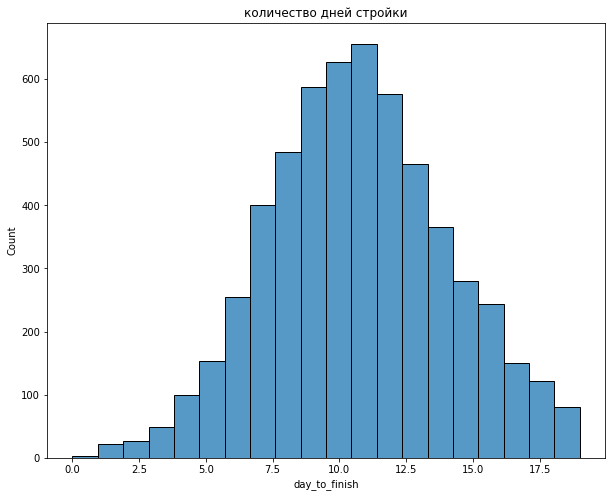

In [23]:
fig, hist = plt.subplots()
hist = sns.histplot(data=day_to_f, x="day_to_finish", bins = 20)
hist.set_title('количество дней стройки') 
fig.set_figwidth(10)
fig.set_figheight(8);

от первой постройки до прекращения игры в среднем проходит 9.753649399302416 дней


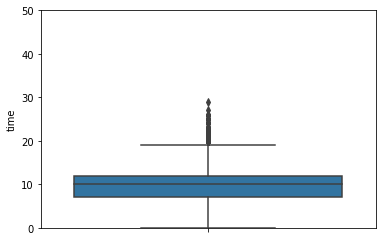

In [24]:
day_to_end = data_not_finished.query('event == "building"').groupby('user_id').apply(lambda x: x['event_datetime'].max() - x['event_datetime'].min()).dt.round('D').reset_index()
day_to_end.columns = ['user_id', 'time']
day_to_end['time'] = (day_to_end['time']/ np.timedelta64(1, 'D')).astype(int) #переводим в формат int

sns.boxplot(y='time', data=day_to_end)
plt.ylim(0, 50);

day_to_end = day_to_end[day_to_end['time'] < 25]
print('от первой постройки до прекращения игры в среднем проходит', day_to_end['time'].mean(), 'дней')

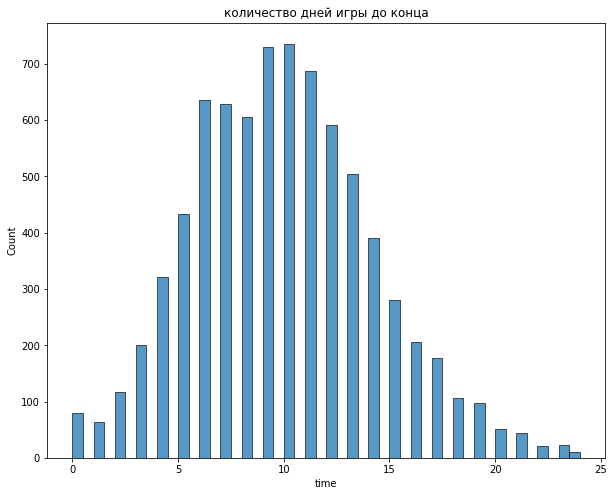

In [25]:
fig, hist = plt.subplots()
hist = sns.histplot(data=day_to_end, x="time")
hist.set_title('количество дней игры до конца') 
fig.set_figwidth(10)
fig.set_figheight(8);

у большинства пользователей заканчивается терпение с 6-11 день, именно в это время др пользователи переходили на 2 уровень 

#### скорость постройки

In [26]:
data_act_buil_1 = data_finished.query('event == "building"')

data_act_buil_1['prev'] = (data_act_buil_1.query('event == "building"').sort_values(by=['event_datetime'], ascending=True)
                       .groupby(['user_id'])['event_datetime'].shift(1))

data_act_buil_1['diff'] = data_act_buil_1['event_datetime'] - data_act_buil_1['prev']

In [27]:
diff_buil_1 = data_act_buil_1['diff'].dropna() #удаляем пустые строки, чтобы перевести в часы
diff_buil_1 = data_act_buil_1.merge(diff_buil_1, on = 'diff', how = 'inner').drop_duplicates()
diff_buil_1['diff'] = (diff_buil_1['diff']/ np.timedelta64(1, 'h')).astype(int)

display(diff_buil_1.head(5))

,event_datetime,event,building_type,user_id,project_type,prev,diff
0,2020-05-04 12:51:34,building,spaceport,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04 00:13:21,12
1,2020-05-04 17:32:03,building,spaceport,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-04 00:22:48,17
2,2020-05-05 03:50:35,building,spaceport,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-04 13:41:55,14
3,2020-05-04 03:32:03,building,spaceport,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-04 00:57:02,2
4,2020-05-05 16:44:34,building,spaceport,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-04 03:32:03,37


In [28]:
#посчитаем для каждого пользователя среднее время между постройками
time_diff_mean = diff_buil_1.groupby('user_id').agg({'diff':'mean'}).reset_index()
time_diff_mean.columns = ['user_id', 'mean_time_building']

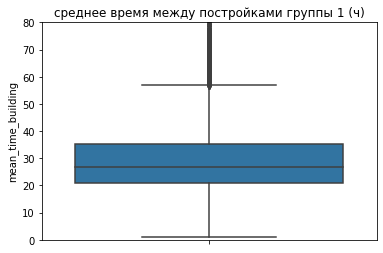

In [29]:
sns.boxplot(y='mean_time_building', data=time_diff_mean)
plt.title('среднее время между постройками группы 1 (ч)')
plt.ylim(0, 80);

In [30]:
a = time_diff_mean[time_diff_mean['mean_time_building'] < 60]

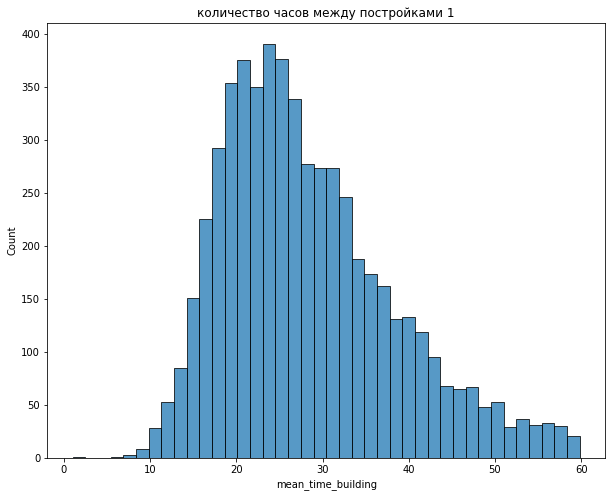

In [31]:
fig, hist = plt.subplots()
hist = sns.histplot(data=a, x="mean_time_building")
hist.set_title('количество часов между постройками 1') 
fig.set_figwidth(10)
fig.set_figheight(8);

In [32]:
print(' у группы 1 в среднем между каждой постройкой проходит', a['mean_time_building'].mean().round(2), 'часов')

 у группы 1 в среднем между каждой постройкой проходит 28.35 часов


In [33]:
data_act_buil = data_not_finished.query('event == "building"')

data_act_buil['prev'] = (data_act_buil.query('event == "building"').sort_values(by=['event_datetime'], ascending=True)
                       .groupby(['user_id'])['event_datetime'].shift(1))

data_act_buil['diff'] = data_act_buil['event_datetime'] - data_act_buil['prev']

In [34]:
diff_buil = data_act_buil['diff'].dropna() #удаляем пустые строки, чтобы перевести в часы
diff_buil = data_act_buil.merge(diff_buil, on = 'diff', how = 'inner').drop_duplicates()
diff_buil['diff'] = (diff_buil['diff']/ np.timedelta64(1, 'h')).astype(int)

display(diff_buil.head(5))

,event_datetime,event,building_type,user_id,project_type,prev,diff
0,2020-05-04 00:57:04,building,assembly_shop,92e9ba5d-c7d2-4297-979f-3c1065a13082,NaN,2020-05-04 00:08:43,0
1,2020-05-04 01:05:31,building,assembly_shop,072c58ad-1501-434b-b38b-ce221cf4f12c,NaN,2020-05-04 00:09:07,0
2,2020-05-04 01:13:37,building,assembly_shop,1cc63c6c-54ac-4a36-b28d-1d012f32b127,NaN,2020-05-04 01:12:36,0
3,2020-05-04 01:14:40,building,spaceport,cd74d4ab-4f44-418d-9f9b-7db1b2d9a794,NaN,2020-05-04 00:29:11,0
4,2020-05-04 01:35:20,building,assembly_shop,aa55831c-082e-4c46-9ea0-edf659eb73de,NaN,2020-05-04 00:16:39,1


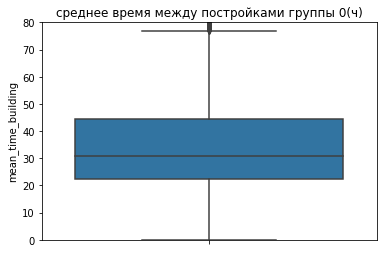

In [35]:
time_diff_mean_0 = diff_buil.groupby('user_id').agg({'diff':'mean'}).reset_index()
time_diff_mean_0.columns = ['user_id', 'mean_time_building']

sns.boxplot(y='mean_time_building', data=time_diff_mean_0)
plt.title('среднее время между постройками группы 0(ч)')
plt.ylim(0, 80);

In [36]:
b = time_diff_mean_0[time_diff_mean_0['mean_time_building'] < 80]

print('в среднем у группы 0 времени между каждой постройков проходит', b['mean_time_building'].mean().round(2), 'часов')

в среднем у группы 0 времени между каждой постройков проходит 33.51 часов


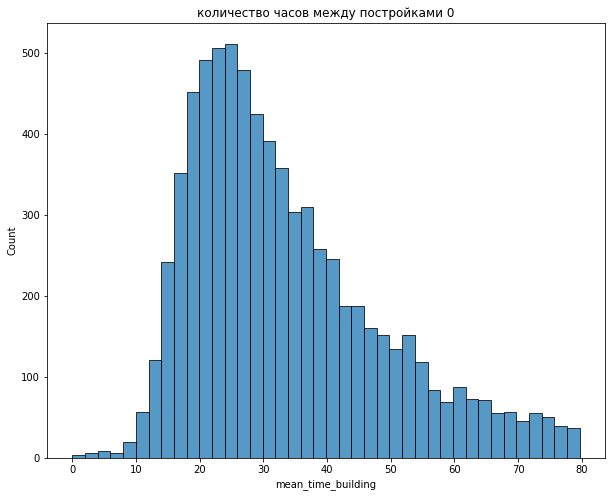

In [37]:
fig, hist = plt.subplots()
hist = sns.histplot(data=b, x="mean_time_building")
hist.set_title('количество часов между постройками 0') 
fig.set_figwidth(10)
fig.set_figheight(8);

#### количество построек

Среднее количество построек у группы 1: 11.0


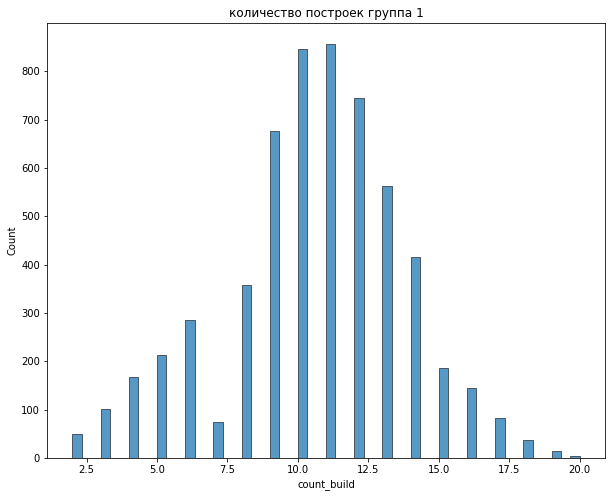

In [38]:
total_1 = pd.concat([data_pve_agg, data_pvp])
print('Среднее количество построек у группы 1:', total_1['count_build'].median().round(2))

fig, hist = plt.subplots()
hist = sns.histplot(data=total_1, x="count_build")
hist.set_title('количество построек группа 1') 
fig.set_figwidth(10)
fig.set_figheight(8);

Среднее количество построек у группы 0: 8.0


,user_id,cnt_buil
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4
3,002f508f-67b6-479f-814b-b05f00d4e995,12
4,003b80c6-4164-4157-bb2a-03d0181d39c4,14
...,...,...
7754,ffbd2858-ded0-487a-be48-723044a1a742,13
7755,ffcf62ae-0992-47ea-a010-2667ee0e7f23,10
7756,ffd3469d-fb9e-49d8-84fe-c1a1aaf4b3b7,11
7757,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16


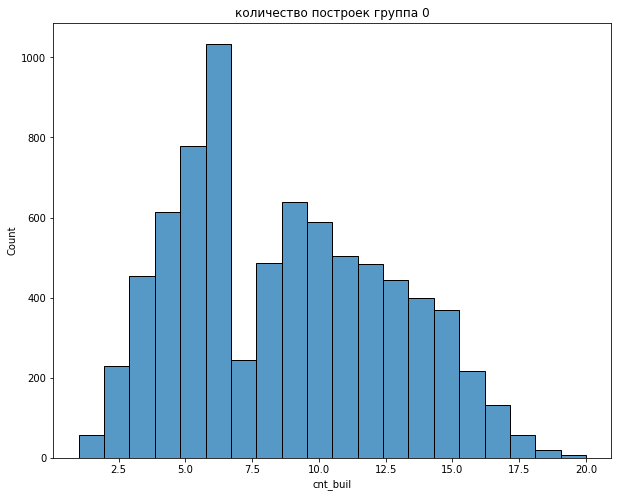

In [39]:
bild_0 = data_not_finished.query('event == "building"').groupby('user_id').agg({'event_datetime':'count'}).reset_index()
bild_0.columns = ['user_id', 'cnt_buil']
print('Среднее количество построек у группы 0:', bild_0['cnt_buil'].median().round(2))
display(bild_0)
fig, hist = plt.subplots()
hist = sns.histplot(data=bild_0, x="cnt_buil", bins = 20)
hist.set_title('количество построек группа 0') 
fig.set_figwidth(10)
fig.set_figheight(8);

**Создадим таблицу со всей нашей подготовленной инф**

In [40]:
total_1 = total_1.merge(day_to_f, on = 'user_id', how = 'inner')

total_1 = total_1.merge(a, on = 'user_id', how = 'inner')

display(total_1)

,user_id,count_build,strategy,day_to_finish,mean_time_building
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,11,PVE,9,20.800000
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,12,PVE,16,33.636364
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,11,PVE,17,41.200000
3,00de2809-403e-4476-a2f7-ca1b11700190,13,PVE,14,26.583333
4,00e83261-5fd4-4939-9616-802b5a0202c6,13,PVE,14,27.250000
...,...,...,...,...,...
5454,ffc6f4fa-3476-47af-85cb-e2ee0551110a,13,PVP,10,20.500000
5455,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,7,PVP,12,48.166667
5456,ffe810f4-1a1f-464b-924d-6f120b0cb8df,16,PVP,13,19.933333
5457,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,PVP,7,21.875000


In [41]:
total_0 = data_not_finished['user_id'].drop_duplicates()
total_0 = day_to_end.merge(total_0, on = 'user_id', how = 'inner')
total_0 = total_0.merge(b, on = 'user_id', how = 'inner')
total_0 = total_0.merge(bild_0, on = 'user_id', how = 'inner')
display(total_0)

,user_id,time,mean_time_building,cnt_buil
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,14,28.333333,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,12,36.375000,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,9,68.666667,4
3,002f508f-67b6-479f-814b-b05f00d4e995,17,35.454545,12
4,003b80c6-4164-4157-bb2a-03d0181d39c4,8,14.769231,14
...,...,...,...,...
7336,ffbd2858-ded0-487a-be48-723044a1a742,18,35.166667,13
7337,ffcf62ae-0992-47ea-a010-2667ee0e7f23,17,44.111111,10
7338,ffd3469d-fb9e-49d8-84fe-c1a1aaf4b3b7,9,21.000000,11
7339,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,10,15.400000,16


#### канал привлечения

In [42]:
#добавим канал привлечения в таблицу
total_1 = total_1.merge(data_users, on = 'user_id', how = 'inner')

total_0 = total_0.merge(data_users, on = 'user_id', how = 'inner')

In [43]:
total_1.groupby('source', as_index = False).agg({'user_id':'count'})

,source,user_id
0,facebook_ads,1089
1,instagram_new_adverts,1375
2,yandex_direct,1906
3,youtube_channel_reklama,1089


In [44]:
total_0.groupby('source', as_index = False).agg({'user_id':'count'})

,source,user_id
0,facebook_ads,1485
1,instagram_new_adverts,1792
2,yandex_direct,2622
3,youtube_channel_reklama,1442


преданность игре не зависит от источника пользователя

## Проверка гипотез

H0 - Различие среднего времени прохождения 1 уровня между пользователями стратегии PvP и PvE отсутствует

H1 - Различие среднего времени прохождения 1 уровня между пользователями стратегии PvP и PvE есть

In [45]:
a = total_1[total_1['strategy'] == 'PVE']['day_to_finish']
b = total_1[total_1['strategy'] == 'PVP']['day_to_finish']

alpha = .05
result = st.ttest_ind(a, b, equal_var=False)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.267841448245505e-56
Отвергаем нулевую гипотезу


__________

H0 - Среднее время между постройками не влияет на завершение 1 уровня

H1 - Среднее время между постройками влияет на завершение 1 уровня


In [46]:
a = total_1['mean_time_building']
b = total_0['mean_time_building']

alpha = .05
result = st.ttest_ind(a, b, equal_var=False)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.65822682004248e-135
Отвергаем нулевую гипотезу


____
H0 - Среднее количество построек между PVP и PVE одинаково

H1 - Среднее количество построек между PVP и PVE различно

In [47]:
a = total_1['count_build']
b = total_0['cnt_buil']

alpha = .05
result = st.ttest_ind(a, b, equal_var=False)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8139642118437013e-154
Отвергаем нулевую гипотезу


что мы имеем, кол-во построек, скороcть прохождения уровня у двух групп различается, среднее время постройки влияет на завершение 1 уровня

_____
## Проверка модели монетизации

один показ рекламы приносит 0.07 у.е

нам известно, что было решено показывать рекламу на экране с выбором постройки

всего было построено 127956 зданий

In [48]:
#Общая сумма затрат на рекламу игры

data_ad_сost['cost'].sum()

#Один показ рекламы приносит 0.07 у.е.

print(round(data_ad_сost['cost'].sum()/0.07, 0), 'нужно показов, чтобы окупить затраты на рекламу')

108623.0 нужно показов, чтобы окупить затраты на рекламу


с текущей моделью затраты на маркетинг окупаются, но можно снизить рекламную нагрузку. Надо еще учесть, что пользователи могли открыть экран с постройкой и до завершения предыдущей. 

Сейчас пользователям показывают рекламу в среднем 10 раз (среднее кол-во построек на пользователя) раз в 20 часов (среднее время между постройками). всего пользователи проводят 240 часов в игре.

1. Предлагаю отвязаться от показа рекламы на экране выбора постройки. И перейти к показу рекламы по времени.

В среднем пользователи строят новое здание раз в 20 часов и играют 10 дней.

Если показывать рекламу раз в сутки, то прибыль = 135760 уе.
Тем самым снизим рекламную нагрузку на пользователей (экран выбора постройки могли открывать и до завершения предыдущей, т.е. до возможности стройки).
И снизим риск снижения дохода при большем количестве пользователей PVP.

In [49]:
data_game_act.groupby('building_type').agg({'user_id':'count'})

,user_id
building_type,
assembly_shop,54494
research_center,14137
spaceport,59325


In [50]:
data_game_act = data_game_act.sort_values(by = ['user_id', 'event_datetime'])
first_buil = data_game_act.groupby('user_id').agg({'event_datetime': 'min', 'building_type': 'first'}).reset_index()

display(first_buil.groupby('building_type').agg({'user_id':'count'}))

,user_id
building_type,
assembly_shop,13576


In [51]:
first_diff = pd.concat([diff_buil_1, diff_buil]).sort_values(by = ['user_id', 'event_datetime'])
first_diff = first_diff.groupby('user_id').agg({'diff': 'first'}).reset_index()
display(first_diff.query('diff < 20').count())

user_id    5968
diff       5968
dtype: int64

2. Пропуск рекламы на первых зданиях.

первая постройка у всех assembly_shop. в среднем можно снизить кол-во рекламы на 1,4 показа на пользователя. 
например, у пользователей, которые чаще заходят в игру можно сделать первые 2 постройки без рекламы(в нашей когорте это 5968 пользователей), у др 1. Т.к. пользователи, которые заходят в игру чаще, вероятнее закончат 1 уровень. 


Дополнительные идеи:

1 Интегрировать рекламу в интерфейс игры (формы зданий, кораблей,
надписи, окраска)

2 Показ рекламы для ускорения постройки (Rewarded video ads). Может
способствовать удержанию пользователей в игре, так и увеличить кол-во пользователей PVE